<a href="https://colab.research.google.com/github/andrelbourgeois/CASA0018/blob/main/simpleTFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created Data


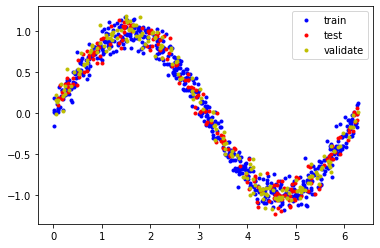


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 16        
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________

Epoch 1/500
12/12 [==============================] - 1s 19ms/step - loss: 0.5385 - mae: 0.6587 - val_loss: 0.5751 - val_mae: 0.6913
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 0.4612 - mae: 0.6015 - val_loss: 0.5204 - val_mae: 0.6443
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 0.4304 - mae: 0.5747 - val_loss: 0.4900 - val_mae: 0.6143
Epoch 4/500
12/12 [==============================] - 0s 9m

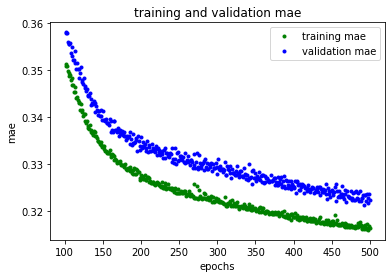

7/7 [==============================] - 0s 2ms/step


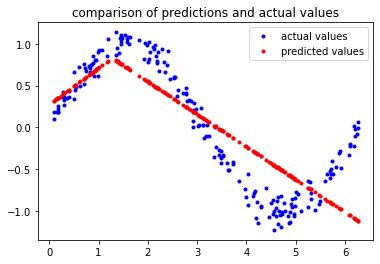

In [5]:
#define paths to model files
#are these file locations on the device???
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR +'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'


#setup environment + import dependencies

#import tensorflow - open source machine learning library
import tensorflow as tf
#import keras - this is tensforflow's high level api for deep learning
from tensorflow import keras
#numpy is a math library
import numpy as np
#pandas is a data manipulation library
import pandas as pd
#matplotlib is a graphing library
import matplotlib.pyplot as plt
#math is python's math library
import math

#set seed for experiment reproducability
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)


#CREATE SOME DATA

#number of sample datapoints
SAMPLES = 1000

#generate a uniformly distributed set of random numbers in the range from
#0 to 2pi, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

#shuffle the values to guarentee they're not in order
np.random.shuffle(x_values)

#calculate the corresponding y values using a sine wave
y_values = np.sin(x_values).astype(np.float32)

#add noise
#add a small random number to y values, approximating something more life-like
y_values += 0.1 * np.random.randn(*y_values.shape)

#the following code will split the data into training (60%), validation (20%),
#and testing (20%) sets
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

#use np.split to chop data into three parts
#the second argument to np.split is an array of indicies where the data will be
#split - we provide two indices so the data will be divided into three chunks
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#double check that our splits add up correctly
assert (x_train.size + x_test.size + x_validate.size) == SAMPLES

#plot our data, the 'b.' argument tells the library to print blue dots, etc
#plot partitions in differenet colours
print('Created Data')
plt.plot(x_train, y_train, 'b.', label='train')
plt.plot(x_test, y_test, 'r.', label='test')
plt.plot(x_validate, y_validate, 'y.', label='validate')
plt.legend()
plt.show()
print()

#--------------------------------------------------------------------

#DESIGN THE MODEL
#we'll use keras to create a simple model architecture
model_1 = tf.keras.Sequential()

#first layer takes a scalar input and feeds it through 16 neurons
#these decide whether to activate based on the relu activation function
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

#the final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

#compile the model using the standar adam optimizer and the
#mean squared error or mse loss function for regression and mean abs error

model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_1.summary()
print()

#TRAIN THE MODEL
#use the data created to train the model that was designed
#this fit will run through the data 500 times (epochs) in groups (batches)
#of 50
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=50,
                        validation_data=(x_validate, y_validate))

#PLOT METRICS

#loss (or mean squared error)
#draw a graph of the loss values, which is the distance between
#the predicted and actual values during the training and validation

train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)
print()
#skip the first few epochs so the graph is easier to read
SKIP = 100

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

#in this example, the loss reduces until ~200 epochs, at which point it's stable
#this means there's no need to train beyond 200 epochs
#however, there is still a ~15% error in predictions

#mean absolute error

plt.clf()

#draw a graph of the mean absolute error, which is another way of
#measuring the maout of error in the prediction

train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='training mae')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='validation mae')
plt.title('training and validation mae')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

#the graph in this example shows a consistently lower training mae then
#validation mae, which indicates overfitting

#ACTUAL VS PREDICTED OUTPUTS
#check predictions against the test dataset from before

#calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

#make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

#graph the predictions against the actual values
plt.clf()

plt.title('comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='actual values')
plt.plot(x_test, y_test_pred, 'r.', label='predicted values')
plt.legend()
plt.show()

#this model will be redesigned in simpleTFLite2.ipynb in order to integrate
#a larger model for more accurate predictions